# ProperImage con DES Cluster Simulation

Vamos a ver como usamos a ProperImage para analizar la PSF de las simulaciones de **DES**.

Para eso es importante primero clonar a ProperImage:

`git clone git@github.com:toros-astro/ProperImage.git`

y luego realizar la instalacion de properimage en nuestro sistema.

Es simplemente moverse al lugar donde esta clonado, y hacer lo siguiente:


`pip install -e .`

Con esto ya podremos entrar a una terminal IPython e importar los modulos de *properimage*

In [1]:
import os

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

#librerias propias
import psf_DES
import test_psf_DES
from properimage import propercoadd as pc
from properimage import utils

In [30]:
from astropy.convolution import convolve

In [48]:
from astropy.nddata.utils import extract_array

## Abriendo una de las imagenes

Vamos a ver como abrir una imagen de **DES Cluster Simulation**

In [2]:
image_path = os.path.abspath('./../imagenes-LN-PSF/im_06_1.fits')

img = fits.getdata(image_path)

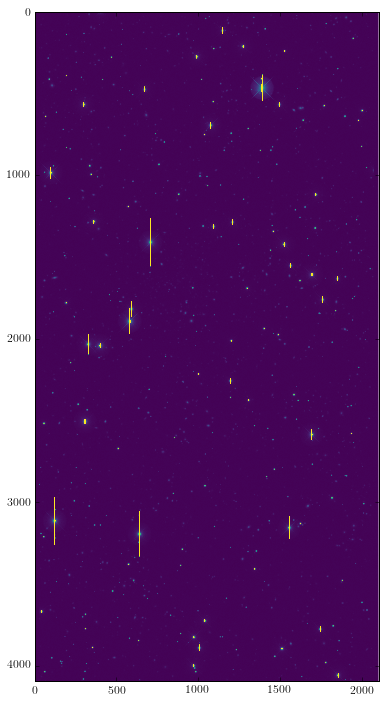

In [3]:
plt.figure(figsize=(8,12))
plt.imshow(np.log10(img), interpolation='none', cmap='viridis')

Como se puede ver la imagen es grande, y posee estrellas saturadas.

Para trabajar con ProperImage es necesario trabajar con instancias del objeto `SingleImage`.

Este objeto esta modificado mediante herencia para DES y se llama en cambio `psf_DES.SingleImageDES`.
Ademas, para trabajar con DES se deben setear parametros importantes, que se relacionan con sextractor:


In [4]:
seeing_par = {}
seeing_par['pixsize'] = 0.27
seeing_par['run'] = 33
seeing_par['filter'] = 'R'
seeing_par['magmax'] = 23.
seeing_par['magmin'] = 18.
seeing_par['fwhmmax'] = 4.5
seeing_par['plot'] = None
seeing_par['img'] = image_path

In [5]:
image = psf_DES.SingleImageDES(seeing_par=seeing_par, img=image_path)

## Extraer una autopsf

Realizar esta operacion es bastante simple, y solo hay un parametro que tal vez queremos modificar.
Dentro del calculo de psf se extraen parches donde estan las mejores estrellas ($P^*_i$), y se generan componentes principales, utilizando una matriz de correlacion $C_{ij} = <P^*_i, P^*_j>$.

Esta matriz genera los autovalores $\lambda_i$ y autovectores $\omega_i$.

El valor de rechazo para los autovalores se impone de forma tal que si $\Lambda = \sum\limits_{j=1} |\lambda_j|$

$\lambda_i / \Lambda > \texttt{pow_th}$

In [6]:
a_fields, psf_basis = image.get_variable_psf(pow_th=0.01)

 
 ------------ seeing:  0.81945
 ------------ imagen:  /home/bruno/Devel/DESCSimulation/imagenes-LN-PSF/im_06_1.fits
 
cantidad de estrellas seleccionadas:  218
cantidad de galaxias seleccionadas:  1545
Sources good to calculate = 218
background subtracted image obtained
background subtracted image obtained
returning best sources
Fitshape = (13, 13)
returning Covariance Matrix
obtainig KL basis, using k = 1
returning variable psf


Para graficar los resultados, podemos utilizar las funciones del modulo **utils** de ProperImage:

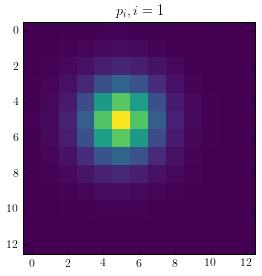

In [7]:
utils.plot_psfbasis(psf_basis=psf_basis, nbook=True)

In [8]:
utils.plot_afields(a_fields=a_fields, shape=img.shape, nbook=True)

No a_fields were calculated. Only one Psf Basis


Como pusimos un $\textttt{pow_th}$ demasiado alto, unicamente una **psf** fue estimada.

Podemos probar con un corte mas relajado; y a la vez introducir una cualidad extra de Properimage: el **contexto**

Esto significa que si queremos limpiar los archivos adicionales que debimos calcular para la imagen anterior debemos ejecutar la siguiente celda:

In [9]:
image._clean()

cleaning... 


En cambio, esto puede ser manejado simplemente con un generador de contexto de Python:

In [10]:
with psf_DES.SingleImageDES(seeing_par=seeing_par, img=image_path) as image:
    a_fields, psf_basis = image.get_variable_psf(pow_th=0.0001)

 
 ------------ seeing:  0.81945
 ------------ imagen:  /home/bruno/Devel/DESCSimulation/imagenes-LN-PSF/im_06_1.fits
 
cantidad de estrellas seleccionadas:  218
cantidad de galaxias seleccionadas:  1545
Sources good to calculate = 218
background subtracted image obtained
background subtracted image obtained
returning best sources
Fitshape = (13, 13)
returning Covariance Matrix
obtainig KL basis, using k = 4

 [astropy.modeling.fitting]




obtaining a fields
returning variable psf
cleaning... 


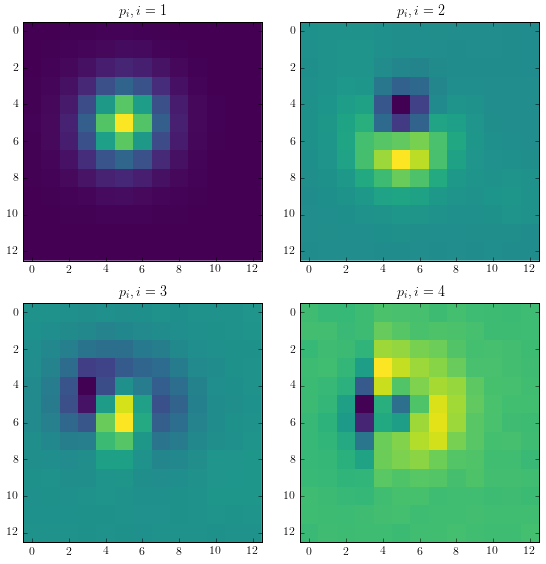

In [11]:
utils.plot_psfbasis(psf_basis=psf_basis, nbook=True)

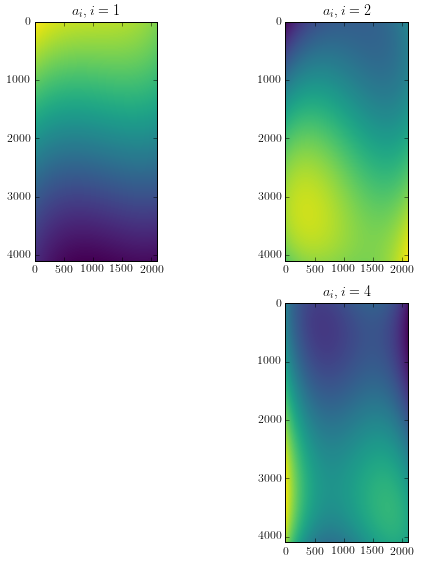

In [12]:
utils.plot_afields(a_fields=a_fields, shape=img.shape, nbook=True)

In [70]:
a = np.zeros_like(img)
x, y = np.mgrid[:img.shape[0], :img.shape[1]]

In [71]:
for x_i in range(100, 3800, 300):
    for y_i in range(100, 2000, 300):
        a[x_i, y_i] = 1. 

In [81]:
rebuild = np.zeros_like(a)

for k in range(len(psf_basis)):
    rebuild = rebuild + convolve(a, psf_basis[k])* a_fields[k](x, y)

rebuild += 10.

In [82]:
patches = []
for x_i in range(100, 3800, 300):
    for y_i in range(100, 2000, 300):
        position = [x_i, y_i+1]
        patch = np.log10(extract_array(rebuild, (12, 12), position))
        patches.append(patch)

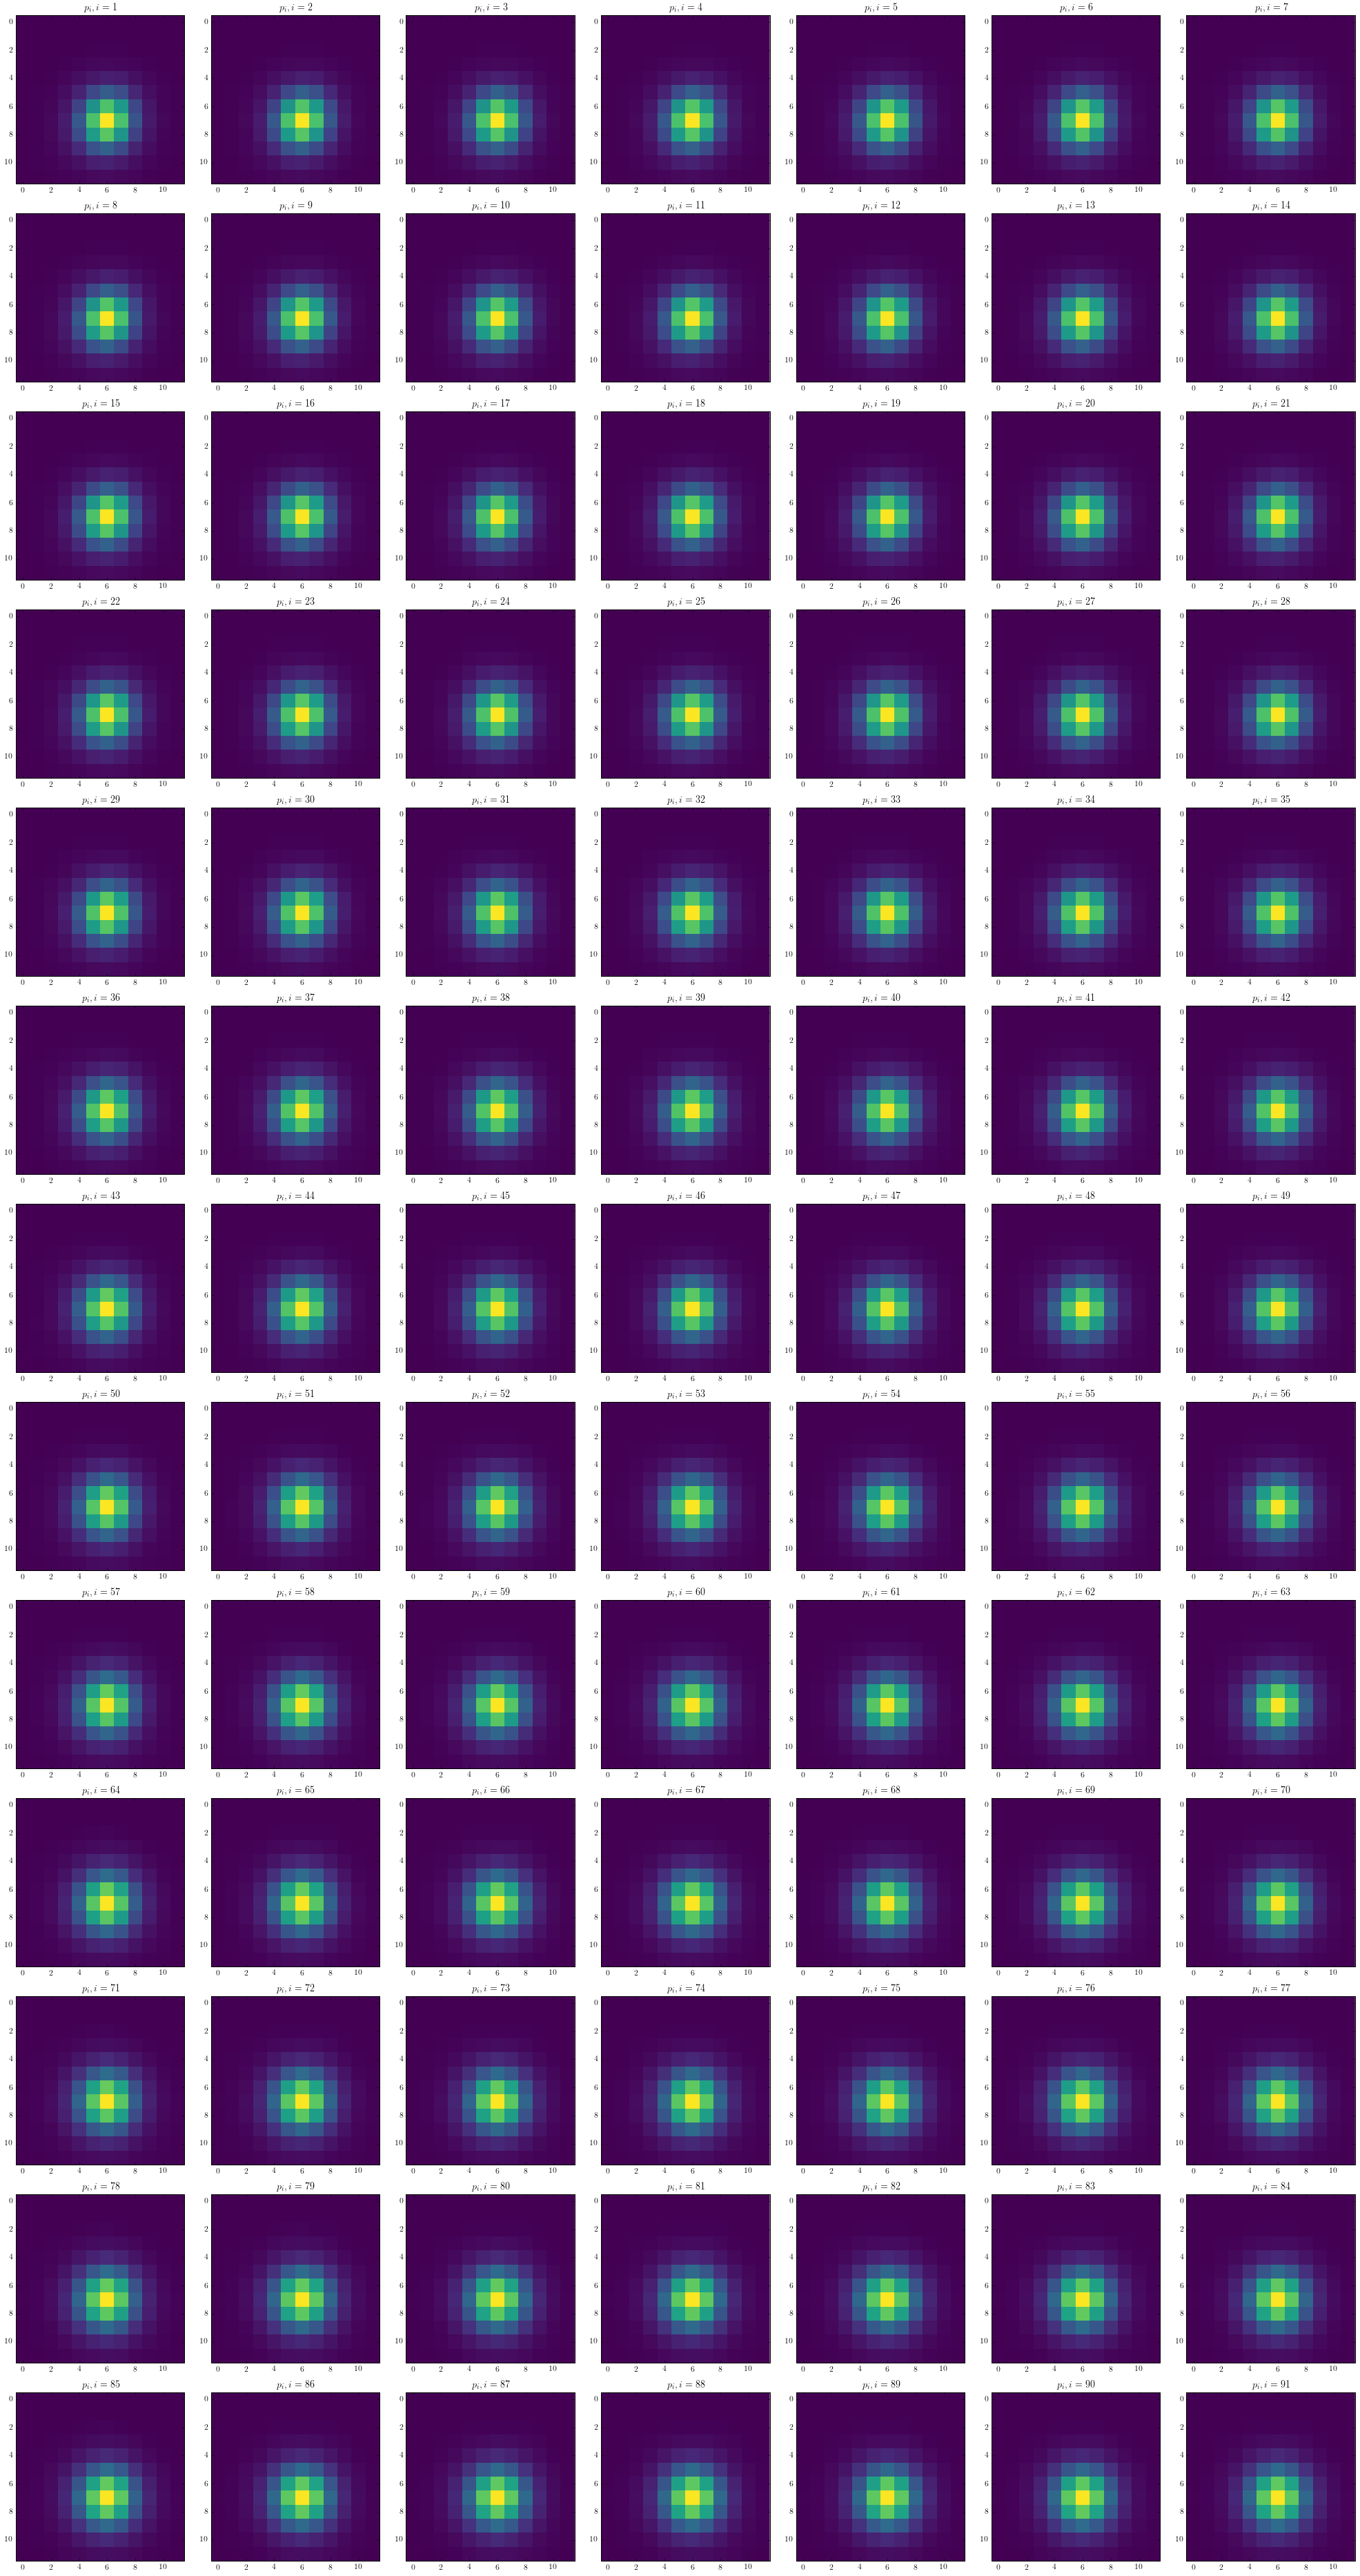

In [83]:
patches.reverse()
utils.plot_psfbasis(psf_basis=patches, nbook=True)